 ####   **本篇结合wealthfront投资白皮书，详细介绍并开源了wealthfront的资产配置方法**
 
 #####   目前国内也出来很多创业团队做这块，其实没有太多神秘的黑科技，优矿瞬间搞定
 #####   结合我国实情，在本篇中给出一个中国版的wealthfront实例
 #####   具体wealthfront投资白皮书，参见链接 https://research.wealthfront.com/whitepapers/investment-methodology/

####  **  wealthfront介绍 **

-  wealthfront是美国知名的在线资产管理平台，目前其管理的资产总额已超过25亿美元https://www.wealthfront.com/

-  以ETF为标的，资产配置为理念，根据客户不同的风险偏好构建不同的投资组合

-  实时跟踪用户组合持仓，给出健康评分，同时根据市场情况和客户风险偏好变化帮用户调整到最优持仓

####  **    投资理念**

- 价值投资（长线投资）：享受经济增长带来的资本增值，并非每个人都有时间看盘，短线投资太累不靠谱

- 被动投资：国内外众多研究表明，长期来看，主动型投资的收益不一定跑得过被动型投资，同时被动投资更容易分散风险

- 资产配置：不要把鸡蛋放在同一个篮子里，做好资产配置，分散掉没有价值非系统性风险

#####  下面，将按照完整的投资步骤详细描述（主要包括选取资产大类，相关性矩阵，构建有效前沿，资产配置方法，组合监控和动态调仓）
#####  并结合中国实情，以具体的例子展开上述过程

####  **  1   选取资产大类 **

- 所选取的资产大类要尽可能涵盖整个市场，而且不同收益特征的都要包括进来，大致可以分为：权益类，债券类和货币类

- 对于每一大类资产，结合我国实情又可以细分很多小类，小类数量不在于多，在于彼此间能够有效地分散掉非系统性风险，使efficient frontier最优

- 最后，选取出来七类资产：国内股市（大盘股、中盘股、小盘股）、国外股市（美股）、国内债券（国债、企业债）、货币基金

- 由于是被动投资，考虑历史数据长短问题，上述七类资产分别以`沪深300、中证500、创业板、标普500、上证国债、上证企业债、博时现金收益A`为代表

#####  不失一般性，下面以过去三年的历史数据计算标的的相关指标，需要特别关注的是相关性系数矩阵，因为需要寻找的是相关性不强甚至是负相关的标的

In [2]:
#  数据准备
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
from pandas import DataFrame, Series
from matplotlib import pyplot as plt

startdate = '20190101'
enddate = '20210101'

secIDs = ['512680.HOF','513100.HOF','512880.HOF','513050.HOF','515050.HOF','510500.HOF','159825.ZOF']   # 
rtns = DataFrame()

for i in range(len(secIDs)):
    cp = DataSource('bar1d_CN_FUND').read(secIDs[i],start_date=startdate,end_date=enddate,fields = ['instrument', 'date', 'close'])  # 
    cp.sort_values('date', inplace = True)
    cp.columns = ['secShortName','tradeDate','return']
    cp['return'][1:] = 1.0 * cp['return'][1:].values / cp['return'][:-1].values - 1  
    cp['return'][:1] = 0
    rtns = pd.concat([rtns,cp],axis = 0)
rtn_table = pd.crosstab(rtns['tradeDate'],rtns['secShortName'], values = rtns['return'], aggfunc = sum)  #  一维表变为二维表
# rtn_table = rtn_table[[6,2,3,5,1,0,4]]
rtn_table.fillna(0, inplace = True)  #  将NaN置换为0
# print(cp)
rtn_table.head(5)

secShortName,159825.ZOF,510500.HOF,512680.HOF,512880.HOF,513050.HOF,513100.HOF,515050.HOF
tradeDate,,,,,,,
2019-01-02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-01-03,0.0,-0.002495,0.018003,0.021008,0.000971,-0.003583,0.0
2019-01-04,0.0,0.027285,0.024116,0.075446,0.006789,-0.000449,0.0
2019-01-07,0.0,0.017264,0.037677,-0.003826,0.028902,0.032374,0.0
2019-01-08,0.0,-0.002176,-0.013616,0.001280,0.007491,0.013937,0.0


先随便计算一下指标，年化收益率，年化标准差

In [3]:
rtn_table.mean() * 250

secShortName
159825.ZOF    0.009679
510500.HOF    0.269689
512680.HOF    0.442200
512880.HOF    0.344567
513050.HOF    0.395214
513100.HOF    0.382165
515050.HOF    0.136972
dtype: float32

In [41]:
rtn_table.std() * np.sqrt(250)

secShortName
159825.ZOF    0.009558
510500.HOF    0.241084
512680.HOF    0.322179
512880.HOF    0.372172
513050.HOF    0.247219
513100.HOF    0.270478
515050.HOF    0.277972
dtype: float32

接下来计算我们关心的相关系数矩阵

In [5]:
rtn_table.corr()

secShortName,159825.ZOF,510500.HOF,512680.HOF,512880.HOF,513050.HOF,513100.HOF,515050.HOF
secShortName,,,,,,,
159825.ZOF,1.000000,0.044204,0.099497,0.082142,0.119938,-0.009011,0.014397
510500.HOF,0.044204,1.000000,0.770466,0.806862,0.554017,0.407018,0.631776
512680.HOF,0.099497,0.770466,1.000000,0.618615,0.319633,0.270338,0.508736
512880.HOF,0.082142,0.806862,0.618615,1.000000,0.437931,0.317054,0.484966
513050.HOF,0.119938,0.554017,0.319633,0.437931,1.000000,0.583057,0.445961
513100.HOF,-0.009011,0.407018,0.270338,0.317054,0.583057,1.000000,0.368573
515050.HOF,0.014397,0.631776,0.508736,0.484966,0.445961,0.368573,1.000000


##### 从上面可以看到：

-  收益相对稳定的债券和货币与其他类的资产相关性都比较低，一方面通过配置可以分散非系统性风险，另一方面在市场不好时可以提供相对稳健的收益
-  标普和国内股市相关性弱，这在进行权益类配置时特别有效，比如在12-14年我国股市表现不佳时，标普500却走出了一波慢牛

#####  ** 接下来，就来对比绘制efficient frontier，从实际中直观感知资产多元化带来的风险分散效果 **

- 构建两个组合作为对比，`组合一`仅包含**沪深300、中证500、创业板、国债、货币**，`组合二`则包含了**组合一、标普500、企业债**
- 绘制effiecient frontier用到了凸优化包cvxopt，关于cvxopt的用法详细介绍，参见。。。。。
- 在构建efficient frontier中，预期收益采取市场中性原则，用过去三年的平均收益

In [14]:
portfolio1 = [0,1,2,4,6]
cov_mat.iloc[portfolio1,portfolio1]

secShortName,159825.ZOF,510500.HOF,512680.HOF,513050.HOF,515050.HOF
secShortName,,,,,
159825.ZOF,0.000091,0.000102,0.000306,0.000283,0.000038
510500.HOF,0.000102,0.058122,0.059844,0.033020,0.042338
512680.HOF,0.000306,0.059844,0.103799,0.025458,0.045561
513050.HOF,0.000283,0.033020,0.025458,0.061117,0.030646
515050.HOF,0.000038,0.042338,0.045561,0.030646,0.077269


In [30]:
from cvxopt import matrix, solvers

portfolio1 = [0,1,2,4,6]
portfolio2 = range(7)
cov_mat = rtn_table.cov() * 250   # 协方差矩阵
exp_rtn = rtn_table.mean() * 250   # 标的预期收益

def cal_efficient_frontier(portfolio): 
    #简单的容错处理
    if len(portfolio) <= 2 or len(portfolio) > 7:
        raise Exception('portfolio必须为长度大于2小于7的list！') 
    # 数据准备
    cov_mat1 = cov_mat.iloc[portfolio, portfolio]
    exp_rtn1 = exp_rtn.iloc[portfolio]
    max_rtn = max(exp_rtn1)
    min_rtn = min(exp_rtn1)
    risks = [] 
    returns = []
    # 均匀选取20个点来作图
    for level_rtn in np.linspace(min_rtn, max_rtn, 20):   
        sec_num = len(portfolio)
        P = 2*matrix(cov_mat1.values)
        q = matrix(np.zeros(sec_num))
        G = matrix(np.diag(-1 * np.ones(sec_num)))
        h = matrix(0.0, (sec_num,1))
        A = matrix(np.matrix([np.ones(sec_num),exp_rtn1.values]))
        b = matrix([1.0,level_rtn])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P,q, G, h, A, b)
        risks.append(sol['primal objective'])
        returns.append(level_rtn)
    return np.sqrt(risks), returns

#  计算画图数据
risk1, return1 = cal_efficient_frontier(portfolio1)
risk2, return2 = cal_efficient_frontier(portfolio2)

在上述准备好数据之后，接下来就构建**组合一**(`沪深300、中证500、创业板、国债、货币`)和**组合二**(`组合一 + 标普500、企业债`)的efficient frontier

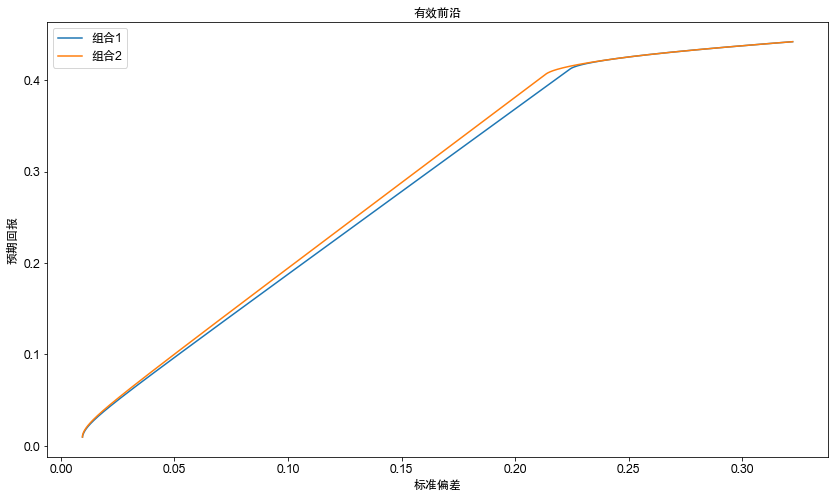

In [31]:
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.plot(risk1,return1)
ax1.plot(risk2,return2)
ax1.set_title('有效前沿', fontsize = 12)
ax1.set_xlabel('标准偏差', fontsize = 12)
ax1.set_ylabel('预期回报', fontsize = 12)
ax1.tick_params(labelsize = 12)
ax1.legend(['组合1','组合2'], loc = 'best', fontsize = 12)

##### 从上图可以很直观地看到：
- 组合一所包含的标的较少，相关性也较高，所以efficient frontier基本为一条直线，分散风险作用不明显

- 组合二引入了和其他资产相关性都不高的标普500，使得efficient frontier得到了很大程度的优化

- 由此也可以知晓，当加入某个标的之后能够使得efficient frontier得到改进的话，那么加入该资产到组合中是非常有必要的

#####  **接下来，给定预期收益，得到最优权重**

- 如上分析，在得到最优的efficient frontier之后（本例中为`组合二`），便可以在资产池中进行资产配置

- 假定某投资者的风险厌恶系数为3（系数越大，表明越厌恶风险，投资更保守），那么就可以借鉴**`均方差优化`**来计算自由的资产配置权重

#####  **附：均值方差优化简介**

- 均值方差模型可以理解成是一个效用函数的最大化，目标效用 = 预期收益带来的正效用 - 承担风险带来的负效用，用公式表示如下：
$$max({u'*w}-{\lambda/2*w'*\Sigma*w})$$
$$\sum w = 1$$
$$0 \leq w \leq 1$$
上式中：$u$为资产的预期收益率，$w$为资产权重，$\lambda$为投资者风险厌恶系数，$\Sigma$为方差协方差矩阵

- 一般情况下，通过给定$u$、$\lambda$、$\Sigma$，就可以计算最优的资产配置权重$w$

- 上式表明，我们仅考虑long only时的情况

In [50]:
portfolio1 = [0,1,2,4,6]
portfolio2 = range(7)
cov_mat = rtn_table.cov() * 250   # 协方差矩阵
exp_rtn = rtn_table.mean() * 250   # 标的预期收益

def cal_efficient_frontier(portfolio): 
    #简单的容错处理
    if len(portfolio) <= 2 or len(portfolio) > 7:
        raise Exception('portfolio必须为长度大于2小于7的list！') 
    # 数据准备
    cov_mat1 = cov_mat.iloc[portfolio, portfolio]
    exp_rtn1 = exp_rtn.iloc[portfolio]
    max_rtn = max(exp_rtn1)
    min_rtn = min(exp_rtn1)
    risks = [] 
    returns = []
    # 均匀选取20个点来作图
#     for level_rtn in np.linspace(min_rtn, max_rtn, 20):
    sec_num = len(portfolio)
    risk_aversion = 3
#         print(exp_rtn1.values)
#         print(matrix(exp_rtn1.values))
    P = risk_aversion * matrix(np.float64(cov_mat1.values))
    q = -1 * matrix(np.float64(exp_rtn1.values))
    G = matrix(np.vstack((np.diag(np.ones(len(exp_rtn1))),np.diag(-np.ones(len(exp_rtn1))))))
    h = matrix(np.array([np.ones(len(exp_rtn1)),np.zeros(len(exp_rtn1))]).reshape(len(exp_rtn1)*2,1))
    A = matrix(np.ones(len(exp_rtn1)),(1,len(exp_rtn1)))
    b = matrix([1.0])
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q, G, h, A, b)
    df_portfolio = DataFrame(index=exp_rtn1.index,data = np.round(sol['x'],2), columns = ['weight'])  # 权重精确到小数点后两位
    print(df_portfolio)
    risks.append(sol['primal objective'])
    returns.append(level_rtn)
    return np.sqrt(risks), returns

#  计算画图数据
risk1, return1 = cal_efficient_frontier(portfolio1)
# risk2, return2 = cal_efficient_frontier(portfolio2)

              weight
secShortName        
159825.ZOF      0.00
510500.HOF      0.00
512680.HOF      0.45
513050.HOF      0.55
515050.HOF      0.00


NameError: name 'level_rtn' is not defined

- 如上所示，在我们的实例中，最优权重配置为58%的创业板，42%的标普500，只配置了两个标的，而且都是权益类的，相对风险较大，这主要是因为风险厌恶系数给定值较小的缘故
- 对于如上配置过程只是一个范例，除此之外，我们还可以定义很多个性化的东西，比如：wealthfront为了保证配置的均匀性，要求每一大类的配置比例都不得超过35%，这些个性化的条件，只用简单的加在优化函数的限制条件里就实现了，读者可以自行实践

#####  **最后，组合监控和动态调仓（rebalance）**
承接上文，在构建好组合之后，
#####  **以上是对wealthfront投资方法的整体介绍，同时详细介绍了我国版的实例，后期优矿可以让大家自己产生这样的策略在优矿上跑，比其他创业产品透明的多喔。**

              weight
secShortName        
159825.ZOF      -0.0
510500.HOF      -0.0
512680.HOF       1.0
512880.HOF       0.0
513050.HOF       0.0
513100.HOF       0.0
515050.HOF      -0.0


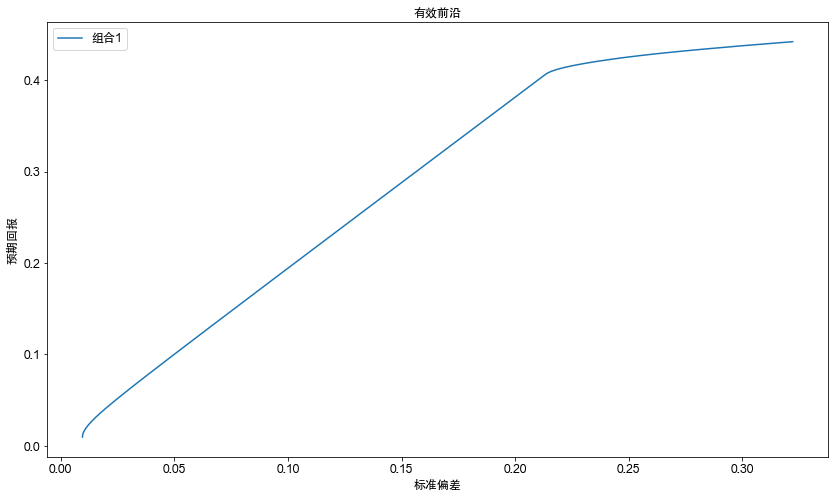

In [52]:
portfolio1 = range(7)
cov_mat = rtn_table.cov() * 250   # 协方差矩阵
exp_rtn = rtn_table.mean() * 250   # 标的预期收益

def cal_efficient_frontier(portfolio): 
    # 数据准备
    cov_mat1 = cov_mat.iloc[portfolio, portfolio]
    exp_rtn1 = exp_rtn.iloc[portfolio]
    max_rtn = max(exp_rtn1)
    min_rtn = min(exp_rtn1)
    risks = [] 
    returns = []
    # 均匀选取20个点来作图
    for level_rtn in np.linspace(min_rtn, max_rtn, 200):   
        sec_num = len(portfolio)
        P = 2*matrix(cov_mat1.values)
        q = matrix(np.zeros(sec_num))
        G = matrix(np.diag(-1 * np.ones(sec_num)))
        h = matrix(0.0, (sec_num,1))
        A = matrix(np.matrix([np.ones(sec_num), exp_rtn1.values]))
        b = matrix([1.0,level_rtn])
        solvers.options['show_progress'] = False
        sol = solvers.qp(P,q, G, h, A, b)
        risks.append(sol['primal objective'])
        returns.append(level_rtn)
    df_portfolio = DataFrame(index=exp_rtn1.index, data = np.round(sol['x'],2), columns = ['weight'])  # 权重精确到小数点后两位
    print(df_portfolio)
    return np.sqrt(risks), returns

#  计算画图数据
risk1, return1 = cal_efficient_frontier(portfolio1)

fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(111)
ax1.plot(risk1,return1)
ax1.set_title('有效前沿', fontsize = 12)
ax1.set_xlabel('标准偏差', fontsize = 12)
ax1.set_ylabel('预期回报', fontsize = 12)
ax1.tick_params(labelsize = 12)
ax1.legend(['组合1'], loc = 'best', fontsize = 12)